### Урок 8. Python применение статистических критериев на практике - пайплайн оценки A/B
На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [61]:
import scipy.stats as s
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [62]:
def H0(stats,alpha):
    print(f'{stats}, alpha={alpha}')
    if stats[1] > alpha:
        print('Статистических различий между группами нет')
    else:
        print('Статистические различия между группами есть')

In [63]:
df = pd.read_excel('AB_Test_Results.xlsx')
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [65]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [66]:
df.isnull().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [67]:
df.VARIANT_NAME.value_counts()

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

In [80]:
df2 = df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique})
df2.head()

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1


In [81]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6324 entries, 0 to 6323
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   USER_ID       6324 non-null   int64
 1   VARIANT_NAME  6324 non-null   int64
dtypes: int64(2)
memory usage: 98.9 KB


In [69]:
more_than_one_types = df2.loc[df2['VARIANT_NAME'] > 1]
more_than_one_types


,USER_ID,VARIANT_NAME
1,3,2
6,10,2
11,18,2
15,25,2
23,40,2
...,...,...
6310,9978,2
6311,9979,2
6313,9982,2
6321,9996,2


In [70]:
# Способ удаления дубликатов из лекции
df_lekciya = df[~df.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')
df_lekciya.head(100)
df_lekciya.shape


(6070, 3)

In [71]:
# Способ удаления дубликатов методом drop_duplicates
df_new = df.drop_duplicates(subset=['USER_ID'], keep=False).sort_values('USER_ID')
df_new.head(100)

,USER_ID,VARIANT_NAME,REVENUE
9077,4,variant,0.0
9155,5,variant,0.0
7720,6,variant,0.0
3920,9,variant,0.0
9661,12,control,0.0
...,...,...,...
4947,244,control,0.0
3297,251,variant,0.0
8622,253,control,0.0
4999,260,variant,0.0


In [72]:
df_new.shape

(3664, 3)

In [73]:
df_new.VARIANT_NAME.value_counts()

VARIANT_NAME
control    1834
variant    1830
Name: count, dtype: int64

### Рекомендации
Проведенный анализ, позволяет сделать вывод, что сплит система настроена не верно, А/В - тест стоит переделать, т.к. выборка уникальных пользователей
не 10000, а 3664 пользователя. Сплит система добавляла пользователя в разные группы и не однократно.

_Если игнорировать несовершенство сплит системы, идем дльше ;)_

In [83]:
control = df_new.loc[df_new['VARIANT_NAME'] == 'control']
control.head()

,USER_ID,VARIANT_NAME,REVENUE
9661,12,control,0.0
4042,21,control,0.0
9932,29,control,0.0
2566,32,control,0.0
8505,42,control,0.0


In [82]:
control.describe()

,USER_ID,REVENUE
count,1834.000000,1834.000000
mean,5049.845692,0.182694
std,2879.580387,4.653008
min,12.000000,0.000000
25%,2591.500000,0.000000
50%,5047.500000,0.000000
75%,7615.000000,0.000000
max,9998.000000,196.010000


In [84]:
variant = df_new.loc[df_new['VARIANT_NAME'] == 'variant']
variant.head()

,USER_ID,VARIANT_NAME,REVENUE
9077,4,variant,0.0
9155,5,variant,0.0
7720,6,variant,0.0
3920,9,variant,0.0
9943,19,variant,0.0


In [85]:
variant.describe()

,USER_ID,REVENUE
count,1830.000000,1830.000000
mean,4966.748087,0.066563
std,2916.198883,0.882727
min,4.000000,0.000000
25%,2393.500000,0.000000
50%,4973.000000,0.000000
75%,7418.750000,0.000000
max,9990.000000,23.040000


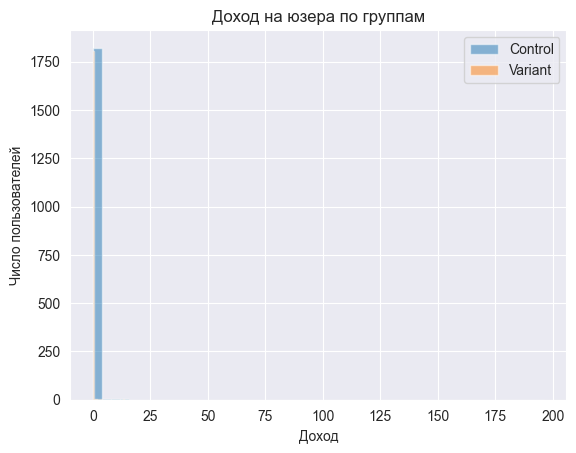

In [76]:
control.REVENUE.hist(bins = 50, alpha =0.5, label='Control')
variant.REVENUE.hist(bins = 50, alpha =0.5, label='Variant')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

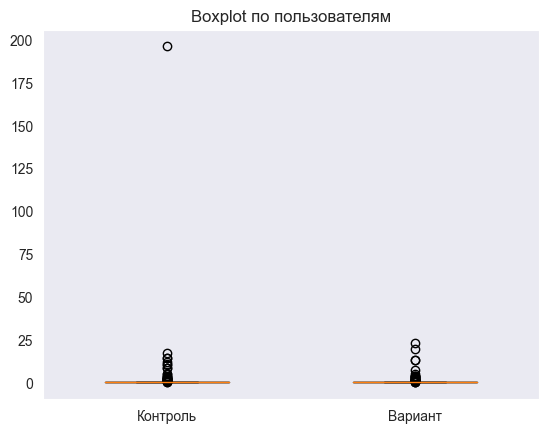

In [77]:
plt.boxplot([control.REVENUE,variant.REVENUE],
            labels=['Контроль','Вариант'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [78]:
a = 0.05
if s.shapiro(control.REVENUE).pvalue > a and s.shapiro(variant.REVENUE).pvalue > a:
    print('Тест на нормальность пройден, применяем ttest')
    H0(s.ttest_ind(control.REVENUE, variant.REVENUE, equal_var = False), a)
else:
    print('Тест на нормальность не пройден, применяем тест Манна-Уитни')
    H0(s.mannwhitneyu(control.REVENUE, variant.REVENUE), a)

Тест на нормальность не пройден, применяем тест Манна-Уитни
MannwhitneyuResult(statistic=1679937.5, pvalue=0.7918208568739313), alpha=0.05
Статистических различий между группами нет


### Вывод:
Оставляем вариан А.

Расчет мощности

In [79]:
from statsmodels.stats.power import TTestIndPower

C_mean = control.REVENUE.values.mean()
V_mean = variant.REVENUE.values.mean()
C_std = control.REVENUE.values.std()
V_std = variant.REVENUE.values.std()
n =  len(control.REVENUE.values)
S = np.sqrt((V_std**2 + C_std **2)/ 2)
ef =float((V_mean-C_mean)/ S)
analysis = TTestIndPower()
result = analysis.solve_power(ef, power=None,
nobs1=n, ratio=1.0, alpha=a)
result

0.18275886733310742

Мощность маленькая, поэтому нельзя доверять результатам теста

# Вывод:
Настроить сплит систему, переделать А/В-тест. На данном этапе оставляем вариан А.